Explanation of what we have here:
1. loading data:
- successfully loading SKCM: gene expression, survival, miRNA
- successfully loading gtex_data (healthy people cells)
- NON SUCCESSFUL: clinical data --> melanoma (problem with rows 38, 39)

2. cleaning and normalizing data that was loaded successfully (relevant to gene_exp, mirna):
    Steps: 
    1. removing unecessary genes (starting with X..)
    2. perform log2(val + 1)
    3. remove features with low variance (we chose to remove values with variance below the 45th percentile)
    4. subtract mean and divide by std

todo:
- load clinical data: I didn't manage with RStudio, maybe you will...
- read about heatmaps with dendograms, gene expression data analysis
- do what nimrod wants, but I think that can happen simply when we know how to use heatmaps/dendograms

In [1]:
#basic data analysis packages
import numpy as np
import pandas as pd

#basic data visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# load data
# description: 

"""
creating dict containing 
- filename (of data provided for the project)
- values: [fist column name, dataset name, separator]
"""

data = {'exp':['gene', 'gene_data', ' '], 
        'mirna': ['micro_rna', 'micro_rna_data', ' '],
        'gtex_data': ['ensemble_id', 'gtex_data', '\t']}

dataframes = {}

"""
load_dataframe will add relevant data to dataframes
"""

def load_dataframe(filename, values):
    title_row = pd.read_csv('{}.csv'.format(filename), header=None, nrows=1) #read table column names as row
    names = title_row.iloc[0, 0].replace('"', '').split(values[2]) #create colum title list
    if filename == 'gtex_data':
        names[0] = values[0]
    else:
        names = [values[0]] + names
    dataframes[values[1]] = pd.read_csv('{}.csv'.format(filename), names=names, skiprows=1, sep=values[2]) #read data    

for x in data.keys():
    load_dataframe(x, data[x])
 


In [3]:
# removing rows from 'exp' where genes begin in "X.." (following discussion with Nimrod, they are irrelevant)
dataframes['gene_data'] = dataframes['gene_data'][~dataframes['gene_data'].gene.str.contains("X..")] 

In [4]:
# load survival data

"""
survival data needs to be loaded in a different way (based on data observation)
we will load it and add it to our dataframes dictionary (for consistency)

the column named "Death" has been renamed as "isDead" for clarity
"""
survival = pd.read_csv('survival.csv', names=['PatientID', 'Survival', 'isDead'], skiprows=1, sep='\t')

dataframes['survival_data'] = survival

In [5]:
def perform_log(dataframe, column_name):
    # perform log2 (val+1)
    dataframe = dataframe.apply(lambda x: np.log2(x + 1) if x.name != column_name else x)
    return dataframe

def remove_low_variance_features(dataframe, percentile_to_remove):
    # find variance per row
    dataframe['std'] = dataframe.std(axis=1)
    # find relevant quantile for variance column
    quantile_value = dataframe['std'].quantile(percentile_to_remove)
    # retain only rows with variance greater than selected quantile
    dataframe = dataframe[dataframe['std'] > quantile_value]
    # drop current varinace column in order to not interfere in future calcuations on full rows
    dataframe = dataframe.drop(['std'], axis=1)
    return dataframe

def subtract_mean_divide_std(dataframe):
    # find mean and std per row
    mean_vals = dataframe.mean(axis=1) #these are the expected values
    std_vals = dataframe.std(axis=1) #this is the variance
    # subtract means and divide by std
    dataframe.iloc[:, 1:] = dataframe.iloc[:, 1:].subtract(mean_vals, axis=0).divide(std_vals, axis=0)
    return dataframe    

"""
normalize data gets 
- a dataframe
- the name of the first column of the dataframe
- the percentile of variance values below which to remove features (to remove features with low variance)
"""
def normalize_data(dataframe, column_name, percentile_to_remove):
    dataframe = perform_log(dataframe, column_name)
    dataframe = remove_low_variance_features(dataframe, percentile_to_remove)
    dataframe = subtract_mean_divide_std(dataframe)
    return dataframe

dataframes['gene_data'] = normalize_data(dataframes['gene_data'], 'gene', 0.45)
dataframes['micro_rna_data'] = normalize_data(dataframes['micro_rna_data'], 'micro_rna', 0.45)

In [1]:
import plotly as py



In [5]:
import statistics

In [ ]:
# dendogram take 1

In [ ]:
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.colors import rgb2hex, colorConverter
from scipy.cluster.hierarchy import set_link_color_palette
import scipy.cluster.hierarchy as sch
%pylab inline

In [18]:
df = dataframes['gene_data'].iloc[:, 1:]
df.head()

,TCGA.3N.A9WB.06,TCGA.3N.A9WC.06,TCGA.3N.A9WD.06,TCGA.BF.A1PU.01,TCGA.BF.A1PV.01,TCGA.BF.A1PX.01,TCGA.BF.A1PZ.01,TCGA.BF.A1Q0.01,TCGA.BF.A3DJ.01,TCGA.BF.A3DL.01,...,TCGA.XV.AB01.06,TCGA.YD.A89C.06,TCGA.YD.A9TA.06,TCGA.YD.A9TB.06,TCGA.YG.AA3N.01,TCGA.YG.AA3O.06,TCGA.YG.AA3P.06,TCGA.Z2.A8RT.06,TCGA.Z2.AA3S.06,TCGA.Z2.AA3V.06
29,0.705057,-0.271497,0.625527,-0.418943,-0.118030,0.281076,0.863096,0.485420,-0.017665,0.703918,...,0.877964,-0.353291,-1.422468,0.171897,0.023153,-0.178889,-2.815216,0.522941,0.578499,1.629794
31,-0.413046,-0.413046,2.578938,0.832644,-0.413046,-0.413046,-0.413046,-0.413046,-0.413046,0.183865,...,-0.413046,-0.413046,-0.413046,-0.413046,0.244972,0.022730,5.881125,-0.413046,-0.034269,0.339950
32,1.757054,1.036223,0.218885,1.061131,-0.537571,0.636080,-0.118952,-0.366040,0.146546,0.262644,...,-0.935667,0.304049,-1.338178,0.883526,0.062297,0.025911,-0.852687,-1.322279,0.955539,-0.830343
33,0.221882,-0.711574,-0.711574,0.248948,-0.504538,2.865197,0.758999,0.124391,2.334234,-0.535345,...,-0.711574,-0.711574,-0.711574,-0.711574,2.575662,-0.711574,-0.711574,-0.711574,-0.599746,-0.711574
34,-2.155411,1.855135,-0.203402,-1.127848,-2.375842,0.318175,-1.807760,-1.162578,2.597457,-0.998403,...,-0.245221,-0.090044,-0.561286,0.104635,-0.732514,0.457520,-0.941446,-0.025598,-1.597626,0.653083


In [19]:
c_dist = pdist(df) # computing the distance

In [21]:
c_link = linkage(df,  metric='correlation', method='complete')# computing the linkage

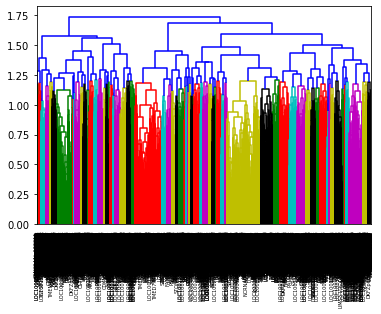

In [30]:
den=dendrogram(c_link,labels=list(dataframes['gene_data']['gene']))

In [ ]:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

# X samples (n x m array), aka data points or "singleton clusters"
# n number of samples (people) - rows
# m number of features (genes) - cols

In [33]:
newdf = dataframes['gene_data'].T
newdf.columns = newdf.iloc[0, :] # use first row as column names
newdf = newdf.iloc[1:, :]
newdf.head()

gene,A1BG.1,A2BP1.54715,A2LD1.87769,A2ML1.144568,A2M.2,A4GALT.53947,AACSL.729522,AADACL2.344752,AADACL3.126767,AADAC.13,...,ZSCAN18.65982,ZSCAN1.284312,ZSCAN23.222696,ZSCAN4.201516,ZSCAN5A.79149,ZSCAN5B.342933,ZSWIM5.57643,ZUFSP.221302,ZYG11A.440590,psiTPTE22.387590
TCGA.3N.A9WB.06,0.705057,-0.413046,1.75705,0.221882,-2.15541,-1.05048,-0.638516,0.942794,-0.161609,-0.536844,...,-0.691598,-0.695362,-1.12565,-0.645632,-1.52158,-1.15934,0.0888119,-0.146231,0.973086,-0.878129
TCGA.3N.A9WC.06,-0.271497,-0.413046,1.03622,-0.711574,1.85513,0.141679,-0.420563,-0.343631,-0.161609,-0.536844,...,1.48047,0.0801927,-0.370815,-0.645632,0.113117,-0.631742,-0.583166,0.0501261,-0.440471,-0.521455
TCGA.3N.A9WD.06,0.625527,2.57894,0.218885,-0.711574,-0.203402,0.818677,-0.0682908,-0.343631,-0.161609,-0.536844,...,1.32691,0.46656,-0.575293,0.0620021,0.738685,0.220998,1.56961,0.0990477,1.6199,2.48323
TCGA.BF.A1PU.01,-0.418943,0.832644,1.06113,0.248948,-1.12785,0.451753,-0.638516,0.262876,-0.161609,-0.536844,...,1.16923,-0.3254,0.469563,-0.645632,-0.663632,-1.15934,0.199847,0.0852827,-0.987508,-0.930842
TCGA.BF.A1PV.01,-0.11803,-0.413046,-0.537571,-0.504538,-2.37584,-0.963777,-0.638516,-0.343631,-0.161609,-0.536844,...,1.14414,-0.351278,-1.17906,-0.645632,0.0860767,-0.750573,-1.92903,-0.221105,-0.987508,-1.14632


In [37]:
X = newdf

In [46]:
# we need to chose one of the methods that can be used to calculate the distance between newly formed clusters. 
# I compared 'ward', 'single', 'complete', 'average' and chose 'average' because it gave c closest to 1

# generate the linkage matrix with 'average'
Z = linkage(X, 'average') 

In [47]:
#other options: 'single', 'complete', 'average', ... and the different distance metrics like 'euclidean' (default), 'cityblock' aka Manhattan, 'hamming', 'cosine'.

In [48]:
# This (very very briefly) compares (correlates) the actual pairwise distances of all your 
# samples to those implied by the hierarchical clustering. The closer the value is to 1, 
# the better the clustering preserves the original distances, 

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.7427531787335907

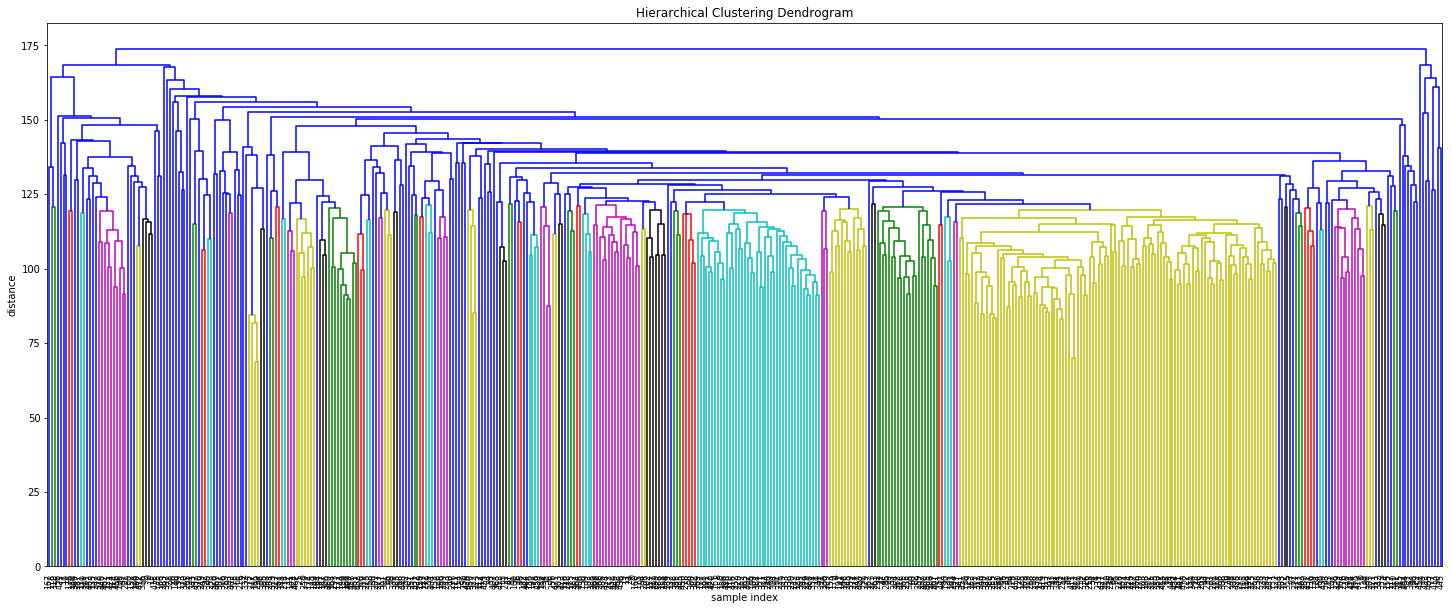

In [52]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

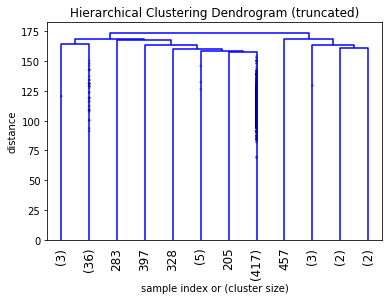

In [60]:

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [222]:
def separate_and_transpose(base_df, name, column_name):
    for group in ['01', '06']:
        #filter dataframe for only primary tumor or only metastasis
        regex = '.{}$|{}'.format(group, column_name) #example: regex='.06$|gene' and regex='.01$|gene'
        dataset_name = '{}_{}'.format(name, group)
        df = base_df.filter(regex=regex,axis=1)
        # transpose dataframe 
        df = df.T # transpose
        df.columns = df.iloc[0, :] # use first row as column names
        df = df.iloc[1:, :]
        dataframes[dataset_name] = df
        
# create dataframes['gene_data_01'], dataframes['gene_data_06']:
separate_and_transpose(dataframes['gene_data'], 'gene_data', 'gene')

# create dataframes['micro_rna_data_01'], dataframes['micro_rna_data_06']:
separate_and_transpose(dataframes['micro_rna_data'], 'micro_rna_data', 'micro_rna')

In [193]:
# df_01, df_06 description: rows == people, columns == genes
#n: the number of genes/mirnas with the biggest difference in medians
def find_differences(df_01, df_06, n):
    # if the dataset contains nulls, replace null cells with 0 values
    df_01 = df_01.fillna(0)
    df_06 = df_06.fillna(0)
    # create mini-datasets that contain the median value for each column
    a = df_01.describe() # a contains median expression for each gene for primary tumor cases (01)
    b = df_06.describe() # b contains median expression for each gene for metastasis cases (06)
    # keep only medians!
    aa = a.loc[a.index == '50%']
    bb = b.loc[b.index == '50%']
    # rename columns for clairty
    aa = aa.rename(index={'50%': '01_median'})
    bb = bb.rename(index={'50%': '06_median'})
    # combine a and b into a new dataset
    median_dataset = pd.concat([aa, bb], axis=0, sort=False).T
    # add abs_difference column to new dataset (this column defines the "distance" between 01 and 06 medians)
    median_dataset['abs_difference'] = abs(median_dataset['01_median'] - median_dataset['06_median'])
    # sort median_dataset by 'abs_difference' (from max difference to min)
    median_dataset = median_dataset.sort_values(by='abs_difference', ascending = False)
    # keep top n rows
    median_dataset = median_dataset.iloc[:n, :]
    # (returning a, b for future calculations)
    return median_dataset, a, b

# get 50 results for gene data:
dataframes['gene_data_medians'], gene_01_description, gene_06_description = find_differences(dataframes['gene_data_01'], dataframes['gene_data_06'], 50)
# get 50 results for mirna data:
dataframes['micro_rna_data_medians'], mirna_01_description, mirna_06_description = find_differences(dataframes['micro_rna_data_01'], dataframes['micro_rna_data_06'], 50)

success1
success2


In [197]:
# create list of genes, mirnas found:
genes_found = list(dataframes['gene_data_medians'].index)
mirna_found = list(dataframes['micro_rna_data_medians'].index)

def minimize_dataset(selected_columns, df_01, df_06):
    df_01 = df_01[selected_columns]
    df_06 = df_06[selected_columns]
    return df_01, df_06
    
genes_found_data_01, genes_found_data_06 = minimize_dataset(genes_found, dataframes['gene_data_01'], dataframes['gene_data_06'])
mirna_found_data_01, mirna_found_data_06 = minimize_dataset(mirna_found, dataframes['micro_rna_data_01'], dataframes['micro_rna_data_06'])

In [207]:
# calculate min and max values for y axis

def create_axis_values(datasets):
    axis_values = {}
    for dataset, num in datasets:
        min_val = dataset.iloc[3, :].min().item()
        max_val = dataset.iloc[-1, :].max().item()
        if "min_val" not in axis_values or min_val < axis_values["min_val"]:
            axis_values["min_val"] = min_val
        if "max_val" not in axis_values or max_val > axis_values["min_val"]:
            axis_values["max_val"] = max_val
    return axis_values

gene_axis = create_axis_values([(gene_01_description, '01'), (gene_06_description, '06')])
mirna_axis = create_axis_values([(mirna_01_description, '01'), (mirna_06_description, '06')])

In [209]:
# graph genes or mirna to see comparison:

# select x (number between 1-49, refering to column order in dataset, to view relevant graph)
# select relevant 01, 06 datasets
# select relevant median_df
# select gene_axis / mirna_axis
def graph(x, df_found_01, df_found_06, median_df, axis_params):
    # create dataset for x only (remove rows where x is zero: dropna that doesn't affect other genes)
    df_01 = df_found_01[df_found_01.iloc[:, x] != 0]
    df_06 = df_found_06[df_found_06.iloc[:, x] != 0]

    data_type_name = df_01.columns[x]
    data_median_01 = median_df.loc[median_df.index == data_type_name]['01_median'].item()
    data_median_06 = median_df.loc[median_df.index == data_type_name]['06_median'].item()

    y = range(int(axis_params["min_val"]-10) , int(axis_params["max_val"]+10))
    fig = plt.figure(figsize=(14,7))
    ax = plt.subplot(1, 1, 1)
    ax.scatter(df_01.index, df_01.iloc[:, x], label="{}_01".format(df_01.columns[x]))
    ax.scatter(df_06.index, df_06.iloc[:, x], label="{}_06".format(df_06.columns[x]))

    horiz_line_01 = np.array([data_median_01 for i in range(len(list(df_01.index)))])
    ax.plot(df_01.index, horiz_line_01, 'r--') 

    horiz_line_06 = np.array([data_median_06 for i in range(len(list(df_06.index)))])
    ax.plot(df_06.index, horiz_line_06, 'r-') 

    plt.legend(loc='upper left');
    plt.show()

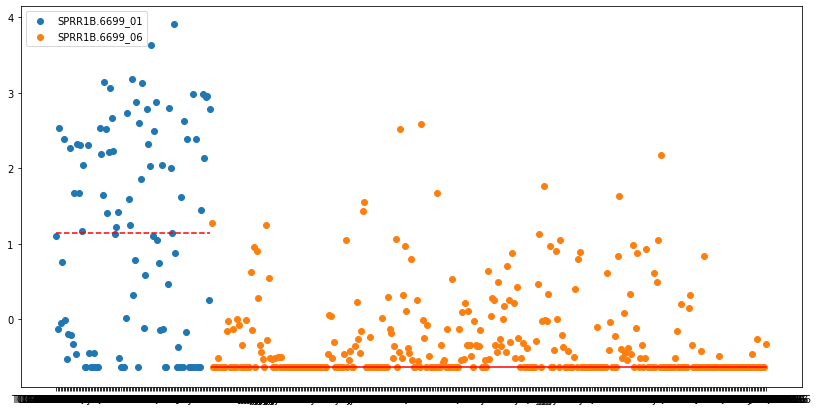

In [211]:
# Examples #1 (genes)
graph(7, genes_found_data_01, genes_found_data_06, dataframes['gene_data_medians'], gene_axis)

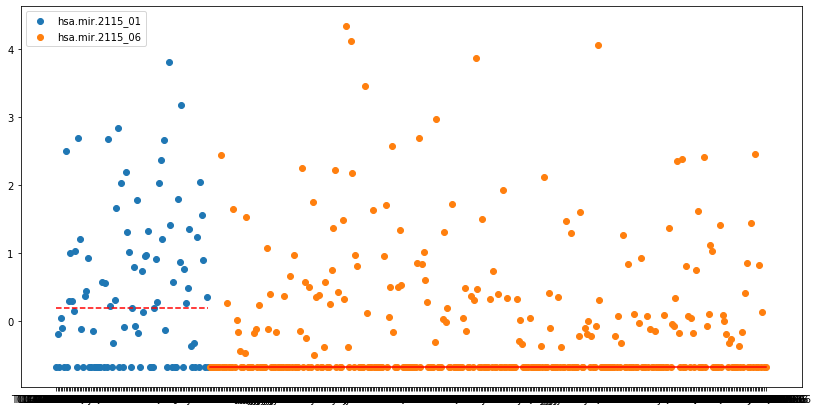

In [213]:
# Examples #2 (mirna)
graph(9, mirna_found_data_01, mirna_found_data_06, dataframes['micro_rna_data_medians'], mirna_axis)

In [120]:
a

gene,A1BG.1,A2BP1.54715,A2LD1.87769,A2ML1.144568,A2M.2,A4GALT.53947,AACSL.729522,AADACL2.344752,AADACL3.126767,AADAC.13,...,ZSCAN18.65982,ZSCAN1.284312,ZSCAN23.222696,ZSCAN4.201516,ZSCAN5A.79149,ZSCAN5B.342933,ZSWIM5.57643,ZUFSP.221302,ZYG11A.440590,psiTPTE22.387590
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,...,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.378261,0.024405,0.171843,0.882802,-0.203643,-0.059610,-0.009605,0.863875,0.162625,0.185089,...,-0.174195,-0.074380,-0.188071,0.238569,-0.001514,-0.101186,0.028260,-0.173722,-0.063916,0.142298
std,0.995113,1.196498,0.982136,1.374454,1.011969,0.834389,0.945949,1.712641,1.311751,1.155560,...,1.060225,1.043196,0.951828,1.186912,0.969624,0.957181,1.023491,1.055943,0.971523,1.195236
min,-2.848987,-0.413046,-2.642376,-0.711574,-2.469226,-1.882601,-0.638516,-0.343631,-0.161609,-0.536844,...,-2.125369,-0.695362,-1.358739,-0.645632,-3.380122,-1.159337,-2.314990,-3.953697,-0.987508,-2.021106
25%,-0.189153,-0.413046,-0.486723,-0.494719,-1.013283,-0.652287,-0.638516,-0.343631,-0.161609,-0.536844,...,-0.985797,-0.695362,-1.001640,-0.645632,-0.609698,-0.954955,-0.547402,-0.670385,-0.700311,-0.635876
50%,0.427778,-0.413046,0.262644,0.577061,-0.140232,-0.176333,-0.398863,-0.343631,-0.161609,-0.536844,...,-0.190763,-0.695362,-0.308988,-0.148302,0.050553,-0.174877,0.199847,-0.058199,-0.338132,-0.152152
75%,0.765849,0.180345,0.773233,2.185779,0.418892,0.480880,0.088286,2.006625,-0.161609,0.484351,...,0.776524,0.153822,0.587873,0.689080,0.445972,0.408806,0.817257,0.568332,0.191782,0.744493
max,3.559694,10.414313,2.446470,3.521356,2.597457,1.868523,3.429139,5.150912,8.723813,4.333063,...,2.037600,4.393101,1.876838,4.848070,2.885078,3.800676,1.656061,2.016407,2.918146,3.907706


In [52]:
len(dataframes['gene_data_01'].columns)

10650

In [56]:
dataframes['gene_data_01'].index

Index(['TCGA.BF.A1PU.01', 'TCGA.BF.A1PV.01', 'TCGA.BF.A1PX.01',
       'TCGA.BF.A1PZ.01', 'TCGA.BF.A1Q0.01', 'TCGA.BF.A3DJ.01',
       'TCGA.BF.A3DL.01', 'TCGA.BF.A3DM.01', 'TCGA.BF.A3DN.01',
       'TCGA.BF.A5EO.01',
       ...
       'TCGA.HR.A5NC.01', 'TCGA.IH.A3EA.01', 'TCGA.WE.A8K4.01',
       'TCGA.XV.A9VZ.01', 'TCGA.XV.A9W2.01', 'TCGA.XV.A9W5.01',
       'TCGA.XV.AAZV.01', 'TCGA.XV.AAZW.01', 'TCGA.XV.AAZY.01',
       'TCGA.YG.AA3N.01'],
      dtype='object', length=103)

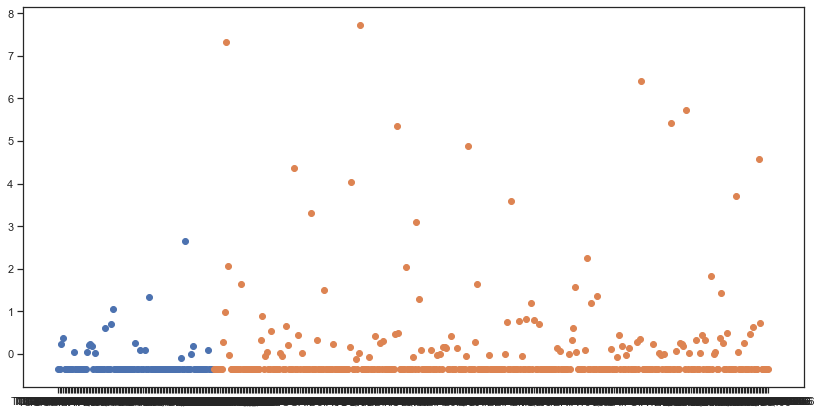

In [121]:
#interresting: 3

y = range(int(min_val_b-10) , int(max_val_b+10))
fig = plt.figure(figsize=(14,7))
ax2 = plt.subplot(1, 1, 1)
#for x in range(10):
#for x in range(100):
#for x in range(10650):
x = 1000
ax2.scatter(dataframes['gene_data_01'].index, dataframes['gene_data_01'].iloc[:, x], label=dataframes['gene_data_01'].columns[x])
ax2.scatter(dataframes['gene_data_06'].index, dataframes['gene_data_06'].iloc[:, x], label=dataframes['gene_data_06'].columns[x])
#plt.legend(loc='upper left');
plt.show()



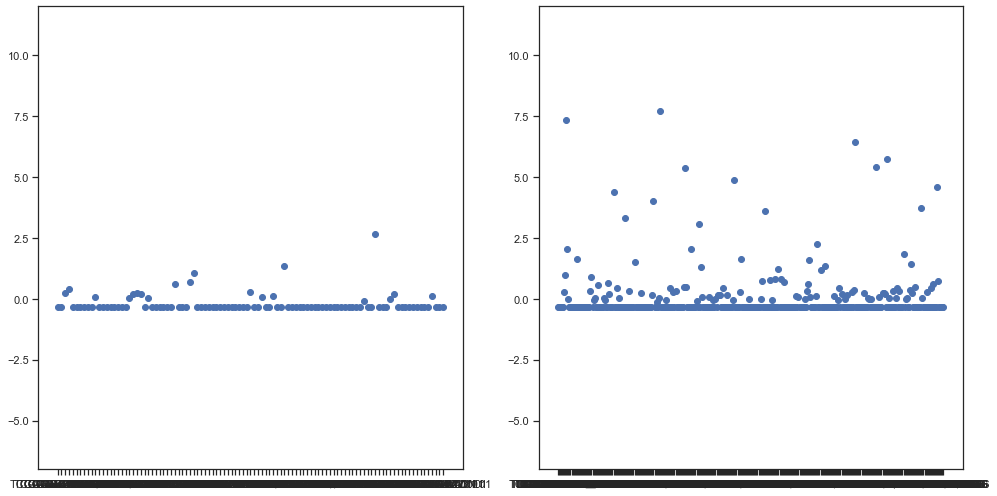

In [122]:
#interresting: 3

y = range(int(min_val_a-10) , int(max_val_a+10))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].set_ylim(int(min_val_a), int(max_val_a))
axes[1].set_ylim(int(min_val_a), int(max_val_a))
#for x in range(10):
x = 1000
axes[0].scatter(dataframes['gene_data_01'].index, dataframes['gene_data_01'].iloc[:, x], label=dataframes['gene_data_01'].columns[x])
axes[1].scatter(dataframes['gene_data_06'].index, dataframes['gene_data_06'].iloc[:, x], label=dataframes['gene_data_06'].columns[x])
fig.tight_layout()

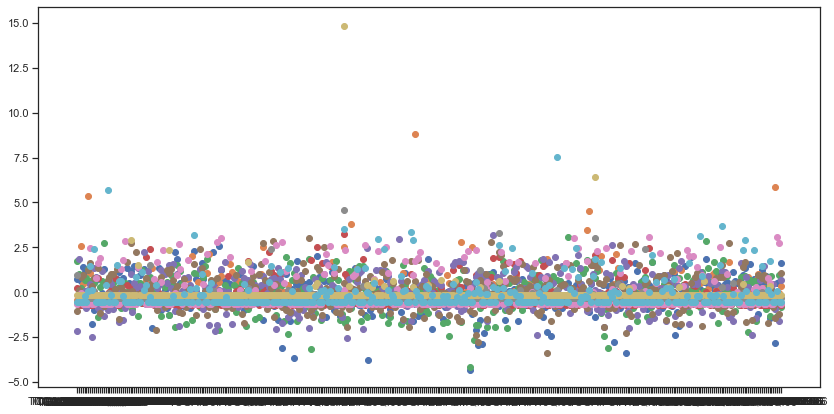

In [101]:
y = range(int(min_val_b-10) , int(max_val_b+10))
fig = plt.figure(figsize=(14,7))
ax2 = plt.subplot(1, 1, 1)
#ax1 = fig.add_subplot(111)
for x in range(10):
#for x in range(100):
#for x in range(10650):
    ax2.scatter(dataframes['gene_data_06'].index, dataframes['gene_data_06'].iloc[:, x], label=dataframes['gene_data_06'].columns[x])
#plt.legend(loc='upper left');
plt.show()


12.23149296065022

In [ ]:
# graph should be:



In [29]:
dataframes['gene_data_01'].to_excel("gene_data_01.xlsx")

In [30]:
dataframes['gene_data_06'] = dataframes['gene_data_06'].fillna(0)
dataframes['gene_data_06'].to_excel("gene_data_06.xlsx")

In [98]:
#create one dataset for 06 and one for 01
#a = dataframes['gene_data'][dataframes['gene_data'].name[-2:] == "06"]
df_06 = dataframes['gene_data'].filter(regex='.06$|gene',axis=1)
df_01 = dataframes['gene_data'].filter(regex='.01$|gene',axis=1)

df_06 = df_06.T # transpose
df_06.columns = df_06.iloc[0, :] # use first row as column names
df_06 = df_06.iloc[1:, :]
df_06.head()

gene,A1BG.1,A1CF.29974,A2BP1.54715,A2LD1.87769,A2ML1.144568,A2M.2,A4GALT.53947,A4GNT.51146,AAA1.404744,AAAS.8086,...,ZUFSP.221302,ZW10.9183,ZWILCH.55055,ZWINT.11130,ZYG11A.440590,ZYG11B.79699,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
TCGA.3N.A9WB.06,381.066,0,0,250.198,7.2698,2209.52,33.5218,0,0,964.863,...,99.3538,370.759,507.654,1418.42,7.2698,644.588,622.779,721.325,2.8271,0
TCGA.3N.A9WC.06,195.182,0,0,160.755,0,169237,105.189,1.2045,0,722.272,...,111.613,236.073,423.13,434.006,0.803,690.154,883.67,1137.81,4.8178,0.4015
TCGA.3N.A9WD.06,360.879,0.7092,6.383,97.1986,0,18257.9,200,0,0,668.794,...,114.894,448.227,213.135,423.404,15.6028,849.645,1105.67,769.504,197.163,0
TCGA.BF.AAP0.06,609.726,0,0.8045,54.1191,0.8045,23157.6,229.284,1.609,0,1202.74,...,118.262,256.235,572.345,654.867,2.0113,383.749,1143.2,444.891,5.2293,0.8045
TCGA.D3.A1Q1.06,499.219,0,0,129.717,0.3582,23780.4,58.7393,0,0,1131.81,...,108.882,434.814,423.388,257.88,1.0745,770.057,1791.91,1346.35,12.1777,0


gene,A1BG.1,A1CF.29974,A2BP1.54715,A2LD1.87769,A2ML1.144568,A2M.2,A4GALT.53947,A4GNT.51146,AAA1.404744,AAAS.8086,...,ZUFSP.221302,ZW10.9183,ZWILCH.55055,ZWINT.11130,ZYG11A.440590,ZYG11B.79699,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
TCGA.3N.A9WB.06,381.066,0,0,250.198,7.2698,2209.52,33.5218,0,0,964.863,...,99.3538,370.759,507.654,1418.42,7.2698,644.588,622.779,721.325,2.8271,0
TCGA.3N.A9WC.06,195.182,0,0,160.755,0,169237,105.189,1.2045,0,722.272,...,111.613,236.073,423.13,434.006,0.803,690.154,883.67,1137.81,4.8178,0.4015
TCGA.3N.A9WD.06,360.879,0.7092,6.383,97.1986,0,18257.9,200,0,0,668.794,...,114.894,448.227,213.135,423.404,15.6028,849.645,1105.67,769.504,197.163,0
TCGA.BF.AAP0.06,609.726,0,0.8045,54.1191,0.8045,23157.6,229.284,1.609,0,1202.74,...,118.262,256.235,572.345,654.867,2.0113,383.749,1143.2,444.891,5.2293,0.8045
TCGA.D3.A1Q1.06,499.219,0,0,129.717,0.3582,23780.4,58.7393,0,0,1131.81,...,108.882,434.814,423.388,257.88,1.0745,770.057,1791.91,1346.35,12.1777,0


Clustering

In [148]:
# transpose gene data, micro rna data

#transpose_data = [dataframes['gene_data'], dataframes['micro_rna_data']]

a = dataframes['gene_data'].T # transpose
a.columns = a.iloc[0, :] # use first row as column names
a = a.iloc[1:, :]
a.columns
# a.rename(columns={" gene ": "patient"})



Index(['A1BG.1', 'A1CF.29974', 'A2BP1.54715', 'A2LD1.87769', 'A2ML1.144568',
       'A2M.2', 'A4GALT.53947', 'A4GNT.51146', 'AAA1.404744', 'AAAS.8086',
       ...
       'ZUFSP.221302', 'ZW10.9183', 'ZWILCH.55055', 'ZWINT.11130',
       'ZYG11A.440590', 'ZYG11B.79699', 'ZZEF1.23140', 'ZZZ3.26009',
       'psiTPTE22.387590', 'tAKR.389932'],
      dtype='object', name='gene', length=19363)

In [91]:
# sample gene data
dataframes['gene_data'].head()

,29,30,31,32,33,34,35,36,37,38,...,20517,20518,20519,20520,20524,20525,20527,20528,20529,20530
gene,A1BG.1,A1CF.29974,A2BP1.54715,A2LD1.87769,A2ML1.144568,A2M.2,A4GALT.53947,A4GNT.51146,AAA1.404744,AAAS.8086,...,ZUFSP.221302,ZW10.9183,ZWILCH.55055,ZWINT.11130,ZYG11A.440590,ZYG11B.79699,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
TCGA.3N.A9WB.06,0.705057,-0.280646,-0.413046,1.75705,0.221882,-2.15541,-1.05048,-0.991263,-0.150562,0.1785,...,-0.146231,0.116896,0.28618,1.52303,0.973086,-0.253298,-2.23982,-0.0997414,-0.878129,-0.284935
TCGA.3N.A9WC.06,-0.271497,-0.280646,-0.413046,1.03622,-0.711574,1.85513,0.141679,0.669905,-0.150562,-0.649788,...,0.0501261,-0.973146,-0.0479013,-0.5587,-0.440471,-0.120323,-1.23257,0.702474,-0.521455,2.52572
TCGA.3N.A9WD.06,0.625527,1.58431,2.57894,0.218885,-0.711574,-0.203402,0.818677,-0.991263,-0.150562,-0.869765,...,0.0990477,0.575522,-1.3043,-0.60213,1.6199,0.284513,-0.58714,0.0140356,2.48323,-0.284935
TCGA.BF.A1PU.01,-0.418943,-0.280646,0.832644,1.06113,0.248948,-1.12785,0.451753,0.0603083,-0.150562,-0.0433683,...,0.0852827,-0.980146,-0.0663148,-0.091513,-0.987508,-1.01398,0.810425,-1.72589,-0.930842,-0.284935


In [70]:
# sample mirna data
dataframes['micro_rna_data'].head()

,micro_rna,TCGA.3N.A9WC.06,TCGA.3N.A9WD.06,TCGA.BF.A1PU.01,TCGA.BF.A1PV.01,TCGA.BF.A1PX.01,TCGA.BF.A1PZ.01,TCGA.BF.A1Q0.01,TCGA.BF.A3DJ.01,TCGA.BF.A3DL.01,...,TCGA.XV.AB01.06,TCGA.YD.A89C.06,TCGA.YD.A9TA.06,TCGA.YD.A9TB.06,TCGA.YG.AA3N.01,TCGA.YG.AA3O.06,TCGA.YG.AA3P.06,TCGA.Z2.A8RT.06,TCGA.Z2.AA3S.06,TCGA.Z2.AA3V.06
0,hsa.let.7a.1,0.237300,1.413978,1.265548,0.185478,0.094122,0.451664,-0.571239,0.519428,2.149726,...,-0.528080,-2.190976,-0.647503,-1.113845,-0.000021,-0.112561,1.255562,-0.427824,-0.161147,1.307661
1,hsa.let.7a.2,0.222888,1.409208,1.264947,0.179001,0.110415,0.445268,-0.566822,0.545780,2.146487,...,-0.535880,-2.168277,-0.645517,-1.087783,0.004459,-0.119957,1.251081,-0.437552,-0.159200,1.300205
2,hsa.let.7a.3,0.224394,1.418898,1.265640,0.156424,0.112991,0.443217,-0.583000,0.563999,2.142916,...,-0.559339,-2.178939,-0.656756,-1.098432,-0.006949,-0.150725,1.272062,-0.431599,-0.102585,1.309069
3,hsa.let.7b,-0.225533,0.833381,1.430398,-0.259191,1.310078,-0.237814,-0.933001,0.950472,1.836045,...,-0.496495,-3.250218,-0.958898,-0.349975,-0.638938,-0.291756,-0.757145,-1.016035,-3.003734,0.182476
4,hsa.let.7c,-1.571869,2.179965,0.263552,0.220736,0.877972,-0.190870,-0.491599,-1.763443,0.910929,...,-1.462939,-2.789086,-1.046594,0.552762,0.439090,-0.992765,2.218663,-1.160461,0.211481,-0.196613


In [71]:
dataframes['gtex_data'].head()

,ensemble_id,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
0,"""ENSG00000227232""",-0.169609,0.054703,0.009834,0.062832,-0.111598,0.013749,0.059378,-0.103492,-0.056906,...,-0.135461,0.031812,-0.033919,-0.083926,0.057796,-0.026684,0.076550,0.074503,-0.024322,0.008076
1,"""ENSG00000238009""",-0.268123,0.129532,-0.226318,-0.594374,-0.247985,0.440750,0.012203,0.023756,0.023010,...,-0.233336,-0.041431,0.150914,0.142757,0.181792,-0.067478,0.196848,0.086229,-0.274816,-0.030805
2,"""ENSG00000233750""",-0.168988,-0.183577,-0.164673,-0.587763,-0.170246,0.177095,0.092399,0.186742,0.050464,...,-0.647793,-0.179416,-0.039154,-0.157434,-0.072724,0.008101,0.326528,-0.103061,-0.018962,-0.099040
3,"""ENSG00000237683""",-0.015901,-0.114264,0.273116,-0.442626,-0.249558,0.040346,0.092957,0.060168,0.024587,...,-0.200647,-0.036321,0.093315,-0.097231,0.055875,-0.226099,-0.198103,-0.151890,-0.091329,-0.023483
4,"""ENSG00000268903""",0.033084,-0.136116,0.357690,-0.209781,-1.040812,0.290923,-0.224477,-0.395459,0.080350,...,-0.395148,0.019980,0.151770,0.050996,0.102515,-0.360847,-0.076868,0.020539,-0.067300,0.040908


In [73]:
# sample survival data
dataframes['survival_data'].head()

,PatientID,Survival,isDead
0,TCGA-3N-A9WB-06,518.0,1.0
1,TCGA-3N-A9WC-06,2022.0,0.0
2,TCGA-3N-A9WD-06,395.0,1.0
3,TCGA-BF-A1PU-01,387.0,0.0
4,TCGA-BF-A1PV-01,14.0,0.0


In [74]:
# load clinical data data

"""
loading with python or excel: problem with rwos 38, 39!!

the data has a problem in line 38, 39:
they are series with 3 elements (total values: 105, unlike total 103 in other rows)
we discluded this data

we tried to load this data with RStudio but it didnt work
"""

clinical_titles = pd.read_csv('melanoma.txt', header=None, nrows=1) 
clinical_data_titles = clinical_titles.iloc[0, 0].split('\t')

clinical_data = pd.read_csv('melanoma.txt', header=None, names=clinical_data_titles, skiprows=[0, 38,39], sep='\t') 

dataframes['clinical_data'] = clinical_data

In [75]:
#sample clinical data
dataframes['clinical_data'].head()

,sampleID,_EVENT,_INTEGRATION,_OS,_OS_IND,_OS_UNIT,_PATIENT,_RFS,_RFS_IND,_RFS_UNIT,...,_GENOMIC_ID_data/public/TCGA/SKCM/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_SKCM_RPPA,_GENOMIC_ID_TCGA_SKCM_mutation_bcm_gene,_GENOMIC_ID_TCGA_SKCM_mutation_broad_gene,_GENOMIC_ID_TCGA_SKCM_gistic2,_GENOMIC_ID_TCGA_SKCM_mutation,_GENOMIC_ID_TCGA_SKCM_exp_HiSeqV2_exon,_GENOMIC_ID_TCGA_SKCM_PDMRNAseqCNV,_GENOMIC_ID_TCGA_SKCM_PDMRNAseq,_GENOMIC_ID_TCGA_SKCM_exp_HiSeqV2_percentile
0,TCGA-3N-A9WB-06,1.0,TCGA-3N-A9WB-06,518.0,1.0,days,TCGA-3N-A9WB,NaN,NaN,days,...,NaN,NaN,NaN,TCGA-3N-A9WB-06A-11D-A38G-08,TCGA-3N-A9WB-06A-11D-A38F-01,NaN,4c243ea9-dfe1-42f0-a887-3c901fb38542,NaN,NaN,4c243ea9-dfe1-42f0-a887-3c901fb38542
1,TCGA-3N-A9WC-06,0.0,TCGA-3N-A9WC-06,2022.0,0.0,days,TCGA-3N-A9WC,2022.0,0.0,days,...,TCGA-3N-A9WC-06,F9B0B31B-24AB-4F30-8EF8-4A4ED282EF04,NaN,TCGA-3N-A9WC-06A-11D-A38G-08,TCGA-3N-A9WC-06A-11D-A38F-01,NaN,a64ae1f5-a189-4173-be13-903bd7637869,NaN,NaN,a64ae1f5-a189-4173-be13-903bd7637869
2,TCGA-3N-A9WD-06,1.0,TCGA-3N-A9WD-06,395.0,1.0,days,TCGA-3N-A9WD,NaN,NaN,days,...,TCGA-3N-A9WD-06,6AFC3678-9499-49A6-AD7A-30F3D185B4BD,NaN,TCGA-3N-A9WD-06A-11D-A38G-08,TCGA-3N-A9WD-06A-11D-A38F-01,NaN,ac19f7cf-670b-4dcc-a26b-db0f56377231,NaN,NaN,ac19f7cf-670b-4dcc-a26b-db0f56377231
3,TCGA-BF-A1PU-01,0.0,TCGA-BF-A1PU-01,387.0,0.0,days,TCGA-BF-A1PU,NaN,NaN,days,...,TCGA-BF-A1PU-01,7E74CAFD-C47B-4F98-A349-BBD2AC699D2D,TCGA-BF-A1PU-01A-11D-A19A-08,TCGA-BF-A1PU-01A-11D-A19A-08,NaN,TCGA-BF-A1PU-01A-11D-A19A-08,9ff4d588-da73-4e26-975d-2b098fe74984,NaN,NaN,9ff4d588-da73-4e26-975d-2b098fe74984
4,TCGA-BF-A1PV-01,0.0,TCGA-BF-A1PV-01,14.0,0.0,days,TCGA-BF-A1PV,14.0,0.0,days,...,TCGA-BF-A1PV-01,NaN,TCGA-BF-A1PV-01A-11D-A19A-08,TCGA-BF-A1PV-01A-11D-A19A-08,NaN,TCGA-BF-A1PV-01A-11D-A19A-08,a57841bb-fa68-4d84-85e0-2d5e4f3ce828,NaN,NaN,a57841bb-fa68-4d84-85e0-2d5e4f3ce828


In [ ]:
#Option 1: cluster all features

In [82]:
# dealing with nulls
#dataframes['micro_rna_data']['TCGA.BF.A1PV.01'].isnull

dataframes['micro_rna_data'].loc[dataframes['micro_rna_data']['TCGA.BF.A1PV.01'].isnull()].shape

(145, 453)

In [77]:
# spectral clustering
from sklearn.cluster import SpectralClustering

X = dataframes['micro_rna_data'].iloc[:, 1:]
clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(X)
clustering

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').